# Exploration and Modeling of 2013 NYC Taxi Trip and Fare Dataset on Spark 2.0 HDInsight Clusters (Scala)

### Last updated:
Jan 08, 2016

---------------------------------
### Here we show some features and capabilities of Spark's MLlib toolkit using the NYC taxi trip and fare data-set from 2013 (about 40 Gb uncompressed). We take a 0.1% sample of this data-set (about 170K rows, 35 Mb) to to show MLlib's modeling features for binary classification and regression problems using this data-set. We have shown relevant plots in Python.

### We have sampled the data in order for the runs to finish quickly. The same code will on the full data-set.

----------------------------------

### OBJECTIVE: Show use of Spark MLlib's functions for featurization and ML tasks.

### We address two learning problems:
#### 1. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip [Using regularized regression]
#### 2. Regression problem: Prediction of the tip amonut ($) [Using random forest]

#### We have shown the following steps:
1. Data ingestion & cleanup
2. Data exploration and plotting
3. Data preparation (featurizing/transformation), 
4. Modeling (using incl. hyperparameter tuning with cross-validation), prediction, model persistance
5. Model evaluation on an independent validation data-set.

### Introductory material

NYC 2013 Taxi data:
http://www.andresmh.com/nyctaxitrips/
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/

An earlier version of this walkthrough was published in a set of notebooks to run on Spark 1.6 HDInsight clusters: https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-data-science-spark-overview

----------------------------------

## Set directory paths and location of training, validation files, as well as model location in blob storage
NOTE: The blob storage attached to the HDI cluster is referenced as: wasb:/// (Windows Azure Storage Blob). Other blob storage accounts are referenced as: wasb://

In [75]:
// Location of training data
val taxi_train_file = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Train.csv";
val taxi_valid_file = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Valid.csv"

// Set model storage directory path. This is where models will be saved.
val modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; //The last backslash is needed;

modelDir: String = wasb:///user/remoteuser/NYCTaxi/Models/

## Set SQL context and import necessary libraries

In [89]:
import org.apache.spark.sql.SQLContext
import org.apache.spark.sql.functions._
import java.text.SimpleDateFormat
import java.util.Calendar

// Spark SQL functions
import org.apache.spark.sql.types.{StringType, IntegerType, FloatType, DoubleType}

// Spark ML and MLlib functions
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.{StringIndexer, VectorAssembler, OneHotEncoder, VectorIndexer, Binarizer, RFormula}
import org.apache.spark.ml.tuning.{ParamGridBuilder, CrossValidator, CrossValidatorModel}
import org.apache.spark.ml.regression.{LinearRegression, LinearRegressionModel, RandomForestRegressor, RandomForestRegressionModel, GBTRegressor, GBTRegressionModel}
import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel, RandomForestClassifier, RandomForestClassificationModel}
import org.apache.spark.ml.evaluation.{BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator}
import org.apache.spark.mllib.evaluation.{BinaryClassificationMetrics, MulticlassMetrics, RegressionMetrics}

val sqlContext = new SQLContext(sc)

sqlContext: org.apache.spark.sql.SQLContext = org.apache.spark.sql.SQLContext@f8f4e7

<a name="ingestion"></a>
## Data ingestion & cleanup: Read in joined 0.1% taxi trip and fare file (as csv), format and clean data, and create data-frame

The taxi trip and fare files were joined based on the instructions provided in: 
"https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/"

A 0.1% sample of the joined data-set was taken to show the ML examples in this walkthrough.

In [3]:
// Read IN TAXI TRAIN DATA
val taxi_train_df = sqlContext.read.format("com.databricks.spark.csv").option("header", "True").option("inferSchema", "True").load(taxi_train_file)

// CLEAN DATA BY DROPPING OR FILTERING SOME FIELDS
val taxi_df_train_cleaned = (taxi_train_df.drop(taxi_train_df.col("medallion"))
        .drop(taxi_train_df.col("hack_license")).drop(taxi_train_df.col("store_and_fwd_flag"))
        .drop(taxi_train_df.col("pickup_datetime")).drop(taxi_train_df.col("dropoff_datetime"))
        .drop(taxi_train_df.col("pickup_longitude")).drop(taxi_train_df.col("pickup_latitude"))
        .drop(taxi_train_df.col("dropoff_longitude")).drop(taxi_train_df.col("dropoff_latitude"))
        .drop(taxi_train_df.col("surcharge")).drop(taxi_train_df.col("mta_tax"))
        .drop(taxi_train_df.col("direct_distance")).drop(taxi_train_df.col("tolls_amount"))
        .drop(taxi_train_df.col("total_amount")).drop(taxi_train_df.col("tip_class"))
        .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200"));

// REGISTER TABLE
taxi_df_train_cleaned.createOrReplaceTempView("taxi_train")

<a name="exploration"></a>
## Data exploration & visualization: Plotting of target variables and features

#### First, summarize data using SQL, this outputs a Spark data frame. If the data-set is too large, it can be sampled

In [4]:
%%sql -q -o sqlResultsPD
SELECT fare_amount, passenger_count, tip_amount, tipped FROM taxi_train WHERE passenger_count > 0 AND passenger_count < 7 AND fare_amount > 0 AND fare_amount < 200 AND payment_type in ('CSH', 'CRD') AND tip_amount > 0 AND tip_amount < 25

#### Plot histogram of tip amount, relationship between tip amount vs. other features

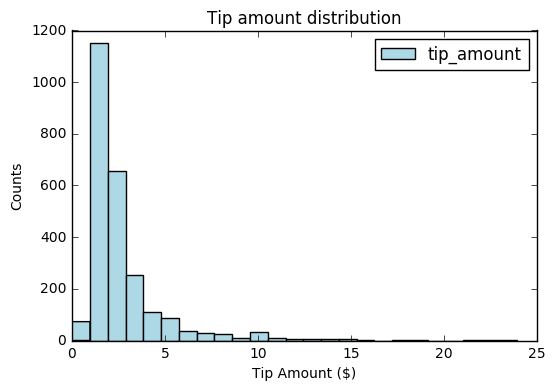

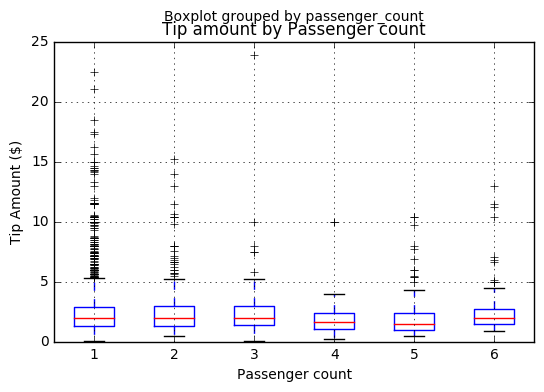

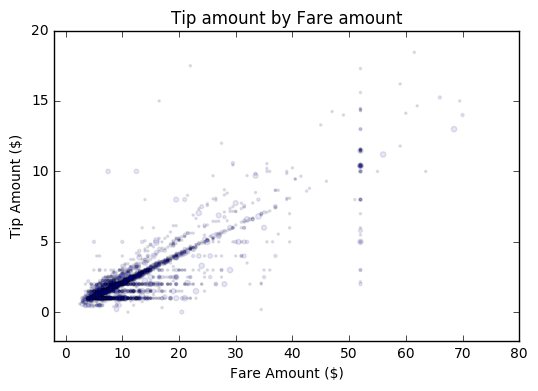

In [5]:
%%local
import matplotlib.pyplot as plt
%matplotlib inline

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP BY PASSENGER COUNT
ax2 = sqlResultsPD.boxplot(column=['tip_amount'], by=['passenger_count'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count'); ax2.set_ylabel('Tip Amount ($)');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResultsPD.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=2.5*(sqlResultsPD.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)'); ax.set_ylabel('Tip Amount ($)');
plt.axis([-2, 80, -2, 20])
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

<a name="transformation"></a>
## Feature engineering, transformation and data preparation for modeling

#### Create a new feature by binning hours into traffic time buckets using Spark SQL

In [6]:
/* CREATE FOUR BUCKETS FOR TRAFFIC TIMES */
val sqlStatement = """
    SELECT *,
    CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
val taxi_df_train_with_newFeatures = sqlContext.sql(sqlStatement)

res21: Long = 126050

#### Indexing and one-hot encoding of categorical features
Here we only transform some variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

For indexing, we used stringIndexer, and for one-hot encoding, we used OneHotEncoder functions from MLlib.

In [81]:
// Create a pipeline of transformations
val sI1 = new StringIndexer().setInputCol("vendor_id").setOutputCol("vendorIndex");
val en1 = new OneHotEncoder().setInputCol("rate_code").setOutputCol("vendorVec");
val sI2 = new StringIndexer().setInputCol("vendor_id").setOutputCol("rateIndex");
val en2 = new OneHotEncoder().setInputCol("rateIndex").setOutputCol("rateVec");
val sI3 = new StringIndexer().setInputCol("payment_type").setOutputCol("paymentIndex");
val en3 = new OneHotEncoder().setInputCol("paymentIndex").setOutputCol("paymentVec");
val sI4 = new StringIndexer().setInputCol("TrafficTimeBins").setOutputCol("TrafficTimeBinsIndex");
val en4 = new OneHotEncoder().setInputCol("TrafficTimeBinsIndex").setOutputCol("TrafficTimeBinsVec");

//encodedFinal = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_train_with_newFeatures);
val featTransformPipeline = new Pipeline().setStages(Array(sI1, en1, sI2, en2, sI3, en3, sI4, en4))
val encodedFinal = featTransformPipeline.fit(taxi_df_train_with_newFeatures).transform(taxi_df_train_with_newFeatures);

encodedFinal: org.apache.spark.sql.DataFrame = [vendor_id: string, rate_code: int ... 19 more fields]

#### Create a random sampling of the data, as needed (50% is used here). This can save some time while training models. Then, split into train/test.

In [15]:
val trainingFraction = 0.5; 
val testingFraction = (1-trainingFraction);
val seed = 1234;
val encodedFinalSampled = encodedFinal.sample(withReplacement = false, fraction = 0.5, seed = seed)


// SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
// INCLUDE RAND COLUMN FOR CREATING CROSS-VALIDATION FOLDS
val splits = encodedFinalSampled.randomSplit(Array(trainingFraction, testingFraction), seed = seed)
val trainData = splits(0)
val testData = splits(1)

testData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [vendor_id: string, rate_code: int ... 19 more fields]

## Binary classification model training: Predicting tip or no tip (target: tipped = 1/0)

### Create logistic regression model, save modle, and evaluate performance of model on test data set

#### Create  logistic regression model using RFormula and LogisticRegression functions

In [91]:
//## TRAIN USING PIPELINE FORMULA + LOGISTIC REGRESSION ESTIMATOR
val logReg = new LogisticRegression().setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)

//## DEFINE TRAINING FORMULA
val classFormula = new RFormula().setFormula("tipped ~ pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount + vendorVec + paymentVec + rateVec + TrafficTimeBinsVec").setFeaturesCol("features").setLabelCol("label")

//## TRAIN PIPELINE MODEL
val pipeline = new Pipeline().setStages(Array(classFormula, logReg));
val model = pipeline.fit(trainData)

// SAVE MODEL
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val logRegDirfilename = modelDir.concat("logisticRegModel_").concat(datestamp)
model.save(logRegDirfilename);

// SCORE AND EVALUATE MODEL ON TEST DATA
val predictions = model.transform(testData)
predictions.registerTempTable("testResults")
predictions.select("label","probability").createOrReplaceTempView("testResults");

val evaluator = new BinaryClassificationEvaluator().setLabelCol("tipped").setRawPredictionCol("probability").setMetricName("areaUnderROC")
val ROC = evaluator.evaluate(predictions)

println("ROC on test data = " + ROC)

ROC on test data = 0.9841004305669758

#### Plot ROC curve from prediction result on test data

In [40]:
%%sql -q -o predictions_pddf
select label, probability from testResults

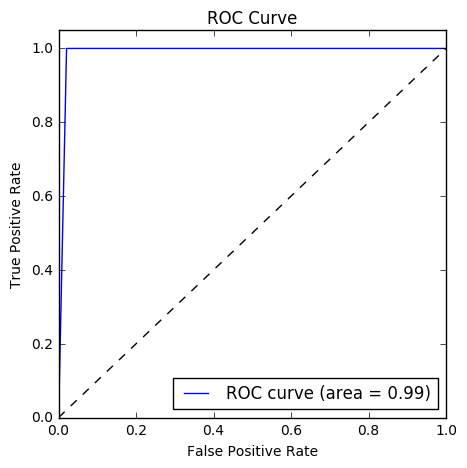

In [41]:
%%local
#PLOT ROC CURVE AFTER CONVERTING PREDICTIONS TO A PANDAS DATA FRAME
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline

labels = predictions_pddf["label"]
prob = []
for dv in predictions_pddf["probability"]:
    prob.append(list(dv.values())[1][1])
    
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
plt.title('ROC Curve'); plt.legend(loc="lower right");
plt.show()

## Train a regression model: Predict the amount of tip paid for taxi trips

### Train a random forest regression model using the Pipeline function, save, and evaluate on test data set

In [55]:
//## DEFINE TRAINING FORMULA
val regFormula = new RFormula().setFormula("tip_amount ~ pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount + vendorVec + paymentVec + rateVec + TrafficTimeBinsVec").setFeaturesCol("features").setLabelCol("label")
val featureIndexer = new VectorIndexer().setInputCol("features").setOutputCol("indexedFeatures").setMaxCategories(32)
val randForest = new RandomForestRegressor().setLabelCol("label").setFeaturesCol("indexedFeatures").setNumTrees(20).setSeed(1234).setMaxDepth(6).setMaxBins(100).setImpurity("variance");


// Fit model, with formula and other transformations
val pipeline = new Pipeline().setStages(Array(regFormula, featureIndexer, randForest))
val model = pipeline.fit(trainData)

// SAVE MODEL
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val randForestDirfilename = modelDir.concat("RandomForestRegressionModel_").concat(datestamp)
model.save(randForestDirfilename);

// MAKE PREDICTIONS ON TEST SET & EVALUATE
val predictions = model.transform(testData)
predictions.registerTempTable("testResults")

val evaluator = new RegressionEvaluator().setLabelCol("tip_amount").setPredictionCol("prediction").setMetricName("r2")
val r2 = evaluator.evaluate(predictions)
println("R-sqr on test data = " + r2)

R-sqr on test data = 0.7826300666458392

In [57]:
%%sql -q -o predictionsPD
select label, prediction from testResults

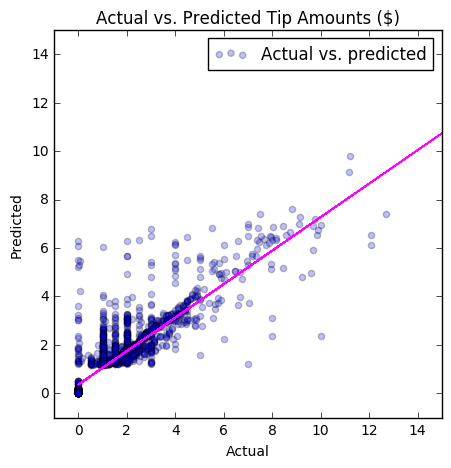

In [58]:
%%local
import matplotlib.pyplot as plt
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 15])
plt.show(ax)

## Load a saved pipeline model and evaluate it on test data set

In [60]:
val savedModel = PipelineModel.load(logRegDirfilename)
val predictions = savedModel.transform(testData)
val evaluator = new BinaryClassificationEvaluator().setLabelCol("tipped").setRawPredictionCol("probability").setMetricName("areaUnderROC")
val ROC = evaluator.evaluate(predictions)

println("ROC on test data = " + ROC)

ROC on test data = 0.9841004305669758

## Hyper-parameter tuning: Train a random forest model using cross-validation

In [77]:
//## DEFINE RANDOM FOREST MODELS
val regFormula = new RFormula().setFormula("tip_amount ~ pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount + vendorVec + paymentVec + rateVec + TrafficTimeBinsVec").setFeaturesCol("features").setLabelCol("label")
val featureIndexer = new VectorIndexer().setInputCol("features").setOutputCol("indexedFeatures").setMaxCategories(32)
val randForest = new RandomForestRegressor().setLabelCol("label").setFeaturesCol("indexedFeatures").setNumTrees(20).setSeed(1234).setMaxDepth(6).setMaxBins(100).setImpurity("variance");


//## DEFINE MODELING PIPELINE, INCLUDING FORMULA, FEATURE TRANSFORMATIONS, AND ESTIMATOR
val pipeline = new Pipeline().setStages(Array(regFormula, featureIndexer, randForest))

//## DEFINE PARAMETER GRID FOR RANDOM FOREST
val paramGrid = new ParamGridBuilder().addGrid(randForest.numTrees, Array(10, 25, 50)).addGrid(randForest.numTrees, Array(3, 5, 7)).build()

//## DEFINE CROSS VALIDATION
val RegEval = new RegressionEvaluator().setMetricName("rmse")
val cv = new CrossValidator().setEstimator(pipeline).setEvaluator(RegEval).setEstimatorParamMaps(paramGrid).setNumFolds(3)

//## TRAIN MODEL USING CV
val cvModel = cv.fit(trainData)

//## PREDICT AND EVALUATE TEST DATA SET
val predictions = cvModel.transform(testData)
val evaluator = new RegressionEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName( "r2")
val r2 = evaluator.evaluate(predictions)
println("R-sqr on test data = " + r2)

//## SAVE THE BEST MODEL
val datestamp = Calendar.getInstance().getTime().toString.replaceAll(" ", ".").replaceAll(":", "_");
val CVDirfilename = modelDir.concat("CV_RandomForestRegressionModel_").concat(datestamp)
cvModel.save(CVDirfilename);

## Load independent validation and evaluate performance of saved pipeline

In [82]:
// Read IN TAXI TRAIN DATA
val taxi_valid_df = sqlContext.read.format("com.databricks.spark.csv").option("header", "True").option("inferSchema", "True").load(taxi_valid_file)

// CLEAN DATA BY DROPPING OR FILTERING SOME FIELDS
val taxi_df_valid_cleaned = (taxi_valid_df.drop(taxi_valid_df.col("medallion"))
        .drop(taxi_valid_df.col("hack_license")).drop(taxi_valid_df.col("store_and_fwd_flag"))
        .drop(taxi_valid_df.col("pickup_datetime")).drop(taxi_valid_df.col("dropoff_datetime"))
        .drop(taxi_valid_df.col("pickup_longitude")).drop(taxi_valid_df.col("pickup_latitude"))
        .drop(taxi_valid_df.col("dropoff_longitude")).drop(taxi_valid_df.col("dropoff_latitude"))
        .drop(taxi_valid_df.col("surcharge")).drop(taxi_valid_df.col("mta_tax"))
        .drop(taxi_valid_df.col("direct_distance")).drop(taxi_valid_df.col("tolls_amount"))
        .drop(taxi_valid_df.col("total_amount")).drop(taxi_valid_df.col("tip_class"))
        .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200"));

//## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_valid_cleaned.createOrReplaceTempView("taxi_valid")

/* CREATE FOUR BUCKETS FOR TRAFFIC TIMES */
val sqlStatement = """
    SELECT *,
    CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_valid 
"""
val taxi_df_valid_with_newFeatures = sqlContext.sql(sqlStatement)
val encodedFinalValid = featTransformPipeline.fit(taxi_df_train_with_newFeatures).transform(taxi_df_valid_with_newFeatures);

encodedFinalValid: org.apache.spark.sql.DataFrame = [vendor_id: string, rate_code: int ... 19 more fields]

In [86]:
val savedModel = CrossValidatorModel.load(CVDirfilename)
val predictions = savedModel.transform(testData)
val r2 = evaluator.evaluate(predictions)
println("R-sqr on test data = " + r2)

R-sqr on test data = 0.7792023043885935